In [1]:
import os
import sys

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
def deltara2sky(deltara, dec):
    '''
    Delta ra_angle to sky_angle

    It is almost equivalent to : real_delta_ra = delta_ra * cos(dec)

    :param deltara: [deg] Delta ra
    :param dec: [deg] absolute dec
    :return: [deg]
    '''
    return np.rad2deg(np.arccos(1. + (np.cos(np.deg2rad(deltara)) - 1.0)*np.cos(np.deg2rad(dec))**2.)     )

In [3]:
fpu = 2

datafile = 'FPU{}_ML_2021-03-22.csv'.format(fpu)
df = pd.read_csv(os.path.join('datasets/', datafile))

# Columns have extra spaces; let's correct that (and remove field, just to keep a fully numeric dataframe; why?)
df = pd.DataFrame(df.values[:, 1:], columns=df.columns.str.strip(' ')[1:], dtype='float64')

# offset ha
# df['ha'] = df['ha']

# Compute X and Y differences for each arm
for i in range(1, 6):
    for d in ['X', 'Y']:
        df['FU{}_d{}'.format(i, d)] = df['FU{}_{}_observed'.format(i, d)] - df['FU{}_{}_calculated'.format(i, d)]

if fpu == 1:
    raise SystemError('No data')
elif fpu == 2:
    reference00 = {1: [716961, 23439970], 2: [848553, 22862347], 3: [377384, 23407169], 
                   4: [-270410, 23304840], 5: [29727, 23524875]}
elif fpu == 3:
    reference00 = {1: [110172, 23584097], 2: [525673, 23515499], 3: [685832, 23188744], 
                   4: [-362080, 22780065], 5: [-741491, 23781604]}

# Compute calculated X and Y delta to center
for i in range(1, 6):
    df['FU{}_Delta_racosdec'.format(i)] = deltara2sky(df['FU{}_Delta_ra'.format(i)], 
                                                      (df['FU{}_dec'.format(i)] + df['dec'])/2 )
    df['FU{}_Delta_X_calculated'.format(i)] = df['FU{}_X_calculated'.format(i)] - reference00[i][0]
    df['FU{}_Delta_Y_calculated'.format(i)] = df['FU{}_Y_calculated'.format(i)] - reference00[i][1]
    df['FU{}_Radius_calculated'.format(i)] = np.sqrt(df['FU{}_Delta_X_calculated'.format(i)]**2 + 
                                                     df['FU{}_Delta_Y_calculated'.format(i)]**2)

cond = df.alt >= 0.0

X = df.loc[cond, ('ha', 'dec', 'temperature', 'airmass', 'alt',
                  'FU1_Delta_racosdec', 'FU1_Delta_dec', 'FU1_Delta_X_calculated', 'FU1_Delta_Y_calculated', 
                  'FU1_Radius_calculated', 'FU1_Delta_Teff',
                  'FU2_Delta_racosdec', 'FU2_Delta_dec', 'FU2_Delta_X_calculated', 'FU2_Delta_Y_calculated', 
                  'FU2_Radius_calculated', 'FU2_Delta_Teff',
                  'FU3_Delta_racosdec', 'FU3_Delta_dec', 'FU3_Delta_X_calculated', 'FU3_Delta_Y_calculated', 
                  'FU3_Radius_calculated', 'FU3_Delta_Teff',
                  'FU4_Delta_racosdec', 'FU4_Delta_dec', 'FU4_Delta_X_calculated', 'FU4_Delta_Y_calculated', 
                  'FU4_Radius_calculated', 'FU4_Delta_Teff',
                  'FU5_Delta_racosdec', 'FU5_Delta_dec', 'FU5_Delta_X_calculated', 'FU5_Delta_Y_calculated', 
                  'FU5_Radius_calculated', 'FU5_Delta_Teff',
                  )]
t = df.loc[cond, ('FU1_dX', 'FU1_dY',
                  'FU2_dX', 'FU2_dY',
                  'FU3_dX', 'FU3_dY',
                  'FU4_dX', 'FU4_dY',
                  'FU5_dX', 'FU5_dY')]


In [4]:
from utils import hat_matrix
hh = hat_matrix(X)

Text(0.5, 0, 'Log(Leverage)')

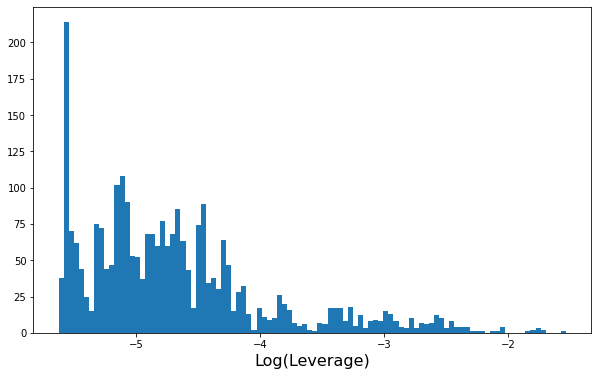

In [97]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

h = ax.hist(np.log(np.diag(hh)), 100)
ax.set_xlabel('Log(Leverage)', fontsize=16)

In [9]:
# Print
print(X.shape, np.sum(np.diag(hh)))


(2627, 35) 36.00000002242063


# Series with different filtering level

In [10]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

In [41]:
# Global test/train separation and scaling
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=1234)

# Leverage computation
lev = np.diag(hat_matrix(X_train))

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Polynomial features
X_train_poly = PolynomialFeatures(degree=2).fit_transform(X_train_scaled)

In [36]:
print('#### Ridge REGRESSION ####')
# Iterate for different limits in leverage

ridge_linears = []

# Linear regression (Ridge)
ridge = Ridge()

for limit in [-1, -2, -3, -4]:
    
    cond = np.log(lev) < limit
    
    print('Limit to log(leverage) < {}; {} in train.'.format(limit, sum(cond)))
    
    # Params
    params = {'alpha': np.logspace(-8, 2, 100)}
    gscv = GridSearchCV(ridge, param_grid=params, cv=5, scoring='neg_mean_squared_error', 
                        n_jobs=5, verbose=1) #, verbose=4)
    
    gscv = gscv.fit(X_train_scaled[cond], t_train[cond])
    print('Best alpha: {:.6f}; Validated score: {:.4f}'.format(gscv.best_params_['alpha'], 
                                                               np.sqrt(-gscv.best_score_)))
    
    ridge_linears.append(gscv.best_estimator_)

#### Ridge REGRESSION ####
Limit to log(leverage) < -1; 2101 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 0.000055; Validated score: 3915.9042
Limit to log(leverage) < -2; 2087 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 0.000043; Validated score: 3797.3856
Limit to log(leverage) < -3; 1957 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 0.000003; Validated score: 2646.2394
Limit to log(leverage) < -4; 1663 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 0.007221; Validated score: 2655.2627


In [39]:
print('#### Lasso REGRESSION ####')

lasso_linears = []

lasso = Lasso(max_iter=10000)

# Iterate for different limits in leverage
for limit in [-1, -2, -3, -4]:
    
    cond = np.log(lev) < limit
    
    print('Limit to log(leverage) < {}; {} in train.'.format(limit, sum(cond)))
    
    # Params
    params = {'alpha': np.logspace(-3, 2, 10)}
    gscv = GridSearchCV(lasso, param_grid=params, cv=5, scoring='neg_mean_squared_error', 
                        n_jobs=5, verbose=1) #, verbose=4)
    
    gscv = gscv.fit(X_train_scaled[cond], t_train[cond])
    print('Best alpha: {:.6f}; Validated score: {:.4f}'.format(gscv.best_params_['alpha'], 
                                                               np.sqrt(-gscv.best_score_)))
    
    lasso_linears.append(gscv.best_estimator_)

#### Lasso REGRESSION ####
Limit to log(leverage) < -1; 2101 in train.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26030306334.362858, tolerance: 27989483.13416316
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11794798094.181965, tolerance: 13350081.793174962
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27074168493.467518, tolerance: 14772005.935098816
  model = cd_fast.enet_coordinate_descent(

Best alpha: 0.001000; Validated score: 4278.2252
Limit to log(leverage) < -2; 2087 in train.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25422209421.584194, tolerance: 27850243.825055953
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10630533477.429068, tolerance: 13008935.087823864
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25699787006.1496, tolerance: 14346943.458127363
  model = cd_fast.enet_coordinate_descent(


Best alpha: 0.001000; Validated score: 4191.9198
Limit to log(leverage) < -3; 1957 in train.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8050445983.5827465, tolerance: 15323994.959126621
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2453618254.5940113, tolerance: 4671083.609703322
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12096950267.829754, tolerance: 12600286.761429844
  model = cd_fast.enet_coordinate_descent(

Best alpha: 0.166810; Validated score: 3253.7914
Limit to log(leverage) < -4; 1663 in train.
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67361138.16839981, tolerance: 11911323.565345645
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4844758.1384038925, tolerance: 3891639.3537724596
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44559126.46137047, tolerance: 10128553.96313145
  model = cd_fast.enet_coordinate_descent(
/

Best alpha: 2.154435; Validated score: 2669.1166


In [43]:
print('#### Ridge Polynomial REGRESSION ####')
# Iterate for different limits in leverage

ridge_poly = []

# Polynomial regression (Ridge)
ridge = Ridge()

for limit in [-1, -2, -3, -4]:
    
    cond = np.log(lev) < limit
    
    print('Limit to log(leverage) < {}; {} in train.'.format(limit, sum(cond)))
    
    # Params
    params = {'alpha': np.logspace(-8, 2, 100)}
    gscv = GridSearchCV(ridge, param_grid=params, cv=5, scoring='neg_mean_squared_error', 
                        n_jobs=5, verbose=1) #, verbose=4)
    
    gscv = gscv.fit(X_train_poly[cond], t_train[cond])
    print('Best alpha: {:.6f}; Validated score: {:.4f}'.format(gscv.best_params_['alpha'], 
                                                               np.sqrt(-gscv.best_score_)))
    
    ridge_poly.append(gscv.best_estimator_)

#### Ridge Polynomial REGRESSION ####
Limit to log(leverage) < -1; 2101 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 62.802914; Validated score: 2312.6038
Limit to log(leverage) < -2; 2087 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 39.442061; Validated score: 2104.0955
Limit to log(leverage) < -3; 1957 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 7.742637; Validated score: 1208.2762
Limit to log(leverage) < -4; 1663 in train.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best alpha: 0.018307; Validated score: 961.6665


In [ ]:
print('#### Lasso Polinomial REGRESSION ####')
# Iterate for different limits in leverage

lasso_poly = []

# Polynomial regression (Lasso)
lasso = Lasso(max_iter=100000)

for limit in [-1, -2, -3, -4]:
    
    cond = np.log(lev) < limit
    
    print('Limit to log(leverage) < {}; {} in train.'.format(limit, sum(cond)))
    
    # Params
    params = {'alpha': np.logspace(-5, 2, 100)}
    gscv = GridSearchCV(ridge, param_grid=params, cv=5, scoring='neg_mean_squared_error', 
                        n_jobs=5, verbose=1) #, verbose=4)
    
    gscv = gscv.fit(X_train_poly[cond], t_train[cond])
    print('Best alpha: {:.6f}; Validated score: {:.4f}'.format(gscv.best_params_['alpha'], 
                                                               np.sqrt(-gscv.best_score_)))
    
    lasso_poly.append(gscv.best_estimator_)

# Find high-leverage obs

In [19]:
lev = np.diag(hh)
df['lev'] = lev

In [23]:
df.sort_values(by='lev', ascending=False).head(10)

,time,temperature,ra,dec,az,alt,airmass,ha,FU1_ra,FU1_dec,...,FU3_Radius_calculated,FU4_Delta_racosdec,FU4_Delta_X_calculated,FU4_Delta_Y_calculated,FU4_Radius_calculated,FU5_Delta_racosdec,FU5_Delta_X_calculated,FU5_Delta_Y_calculated,FU5_Radius_calculated,lev
1935,1.611127e+09,15.1,192.285128,9.180708,45.822984,39.404323,1.575327,-0.595989,192.553735,8.847048,...,3.213109e+07,0.039070,-20012038.0,-32917787.0,3.852353e+07,0.188013,17545181.0,-22568557.0,2.858624e+07,0.215878
2472,1.575420e+09,13.1,53.559271,-44.517694,126.526851,53.759965,1.239853,-0.729035,53.871394,-44.577810,...,2.898375e+07,0.227093,6769422.0,-23310034.0,2.427309e+07,0.115016,6358829.0,-12351885.0,1.389258e+07,0.178335
2473,1.575505e+09,13.7,53.559294,-44.517685,125.634191,49.959588,1.306181,-0.823052,53.871416,-44.577801,...,2.898499e+07,0.227093,6769323.0,-23309269.0,2.427232e+07,0.115016,6359451.0,-12349998.0,1.389119e+07,0.178257
18,1.608963e+09,14.1,144.521161,-21.495234,79.320192,63.679768,1.115661,-0.487251,144.540377,-21.661027,...,3.095796e+07,0.173213,14986779.0,-4320124.0,1.559702e+07,0.252730,14665060.0,-27369694.0,3.105099e+07,0.172706
265,1.575854e+09,14.0,340.813535,-69.193936,199.239411,43.250939,1.459439,0.742094,340.368677,-69.314809,...,1.064728e+07,0.070539,-12995147.0,-27921653.0,3.079761e+07,0.321709,-8248339.0,-25980987.0,2.725888e+07,0.172536
17,1.580096e+09,15.3,144.510609,-21.491091,86.112679,54.987695,1.220958,-0.662533,144.529831,-21.656881,...,3.096128e+07,0.173208,14983591.0,-4318230.0,1.559343e+07,0.252752,14666364.0,-27365440.0,3.104786e+07,0.171034
1442,1.577666e+09,17.6,64.502323,-12.171968,65.332993,56.930927,1.193298,-0.531916,64.244284,-12.308745,...,2.124227e+07,0.076131,-21993451.0,-19105023.0,2.913269e+07,0.075586,-12855642.0,-2481121.0,1.309288e+07,0.162850
1443,1.578011e+09,17.5,64.502451,-12.171942,60.063108,60.492246,1.149044,-0.451776,64.244412,-12.308718,...,2.124144e+07,0.076131,-21992994.0,-19104911.0,2.913227e+07,0.075586,-12855771.0,-2481785.0,1.309313e+07,0.162776
1444,1.583970e+09,16.0,64.504666,-12.171489,293.250641,55.827994,1.208671,0.556154,64.246625,-12.308261,...,2.123414e+07,0.076138,-21982004.0,-19114637.0,2.913036e+07,0.075582,-12858840.0,-2493362.0,1.309834e+07,0.161903
1112,1.583481e+09,18.8,245.808393,-39.282704,119.093089,60.997270,1.143384,-0.579194,245.830161,-39.536312,...,2.085987e+07,0.211313,2282761.0,-27196238.0,2.729187e+07,0.224001,-3562274.0,-18789445.0,1.912415e+07,0.130805


# Residuals

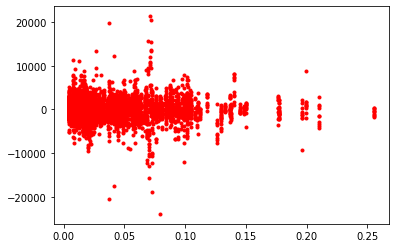

In [49]:
y_train = ridge_poly[0].predict(X_train_poly)
plt.plot(lev, t_train - y_train, '.r')

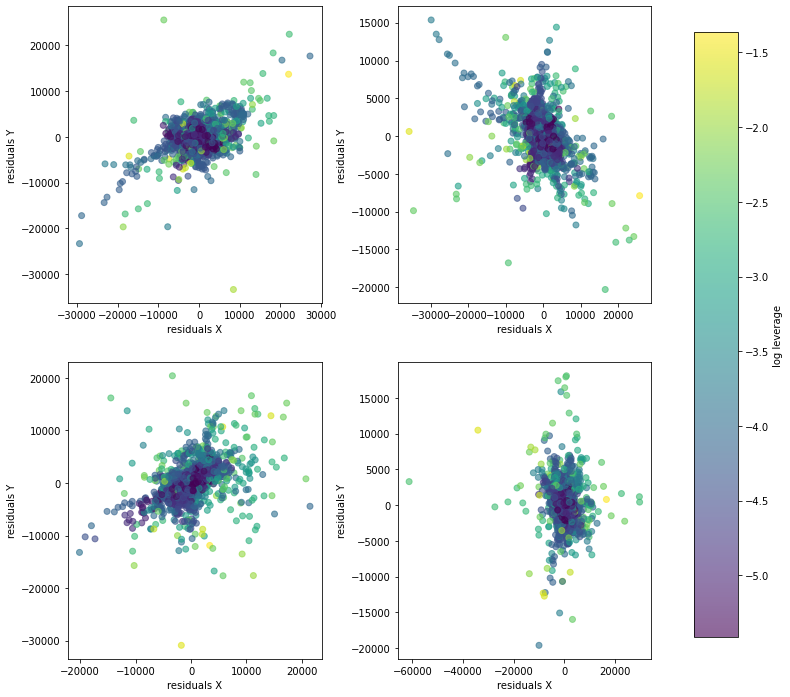

In [80]:
y_train = ridge_linears[0].predict(X_train_scaled)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flatten()):
    aa= ax.scatter(t_train.iloc[:, 2*i] - y_train[:, 2*i], 
                   t_train.iloc[:, 2*i + 1] - y_train[:, 2*i + 1], c=np.log(lev), alpha=0.6)
    ax.set_xlabel('residuals X')
    ax.set_ylabel('residuals Y')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(aa, cax=cbar_ax, label='log leverage')

Text(0.5, 0.08, 'log(Leverage)')

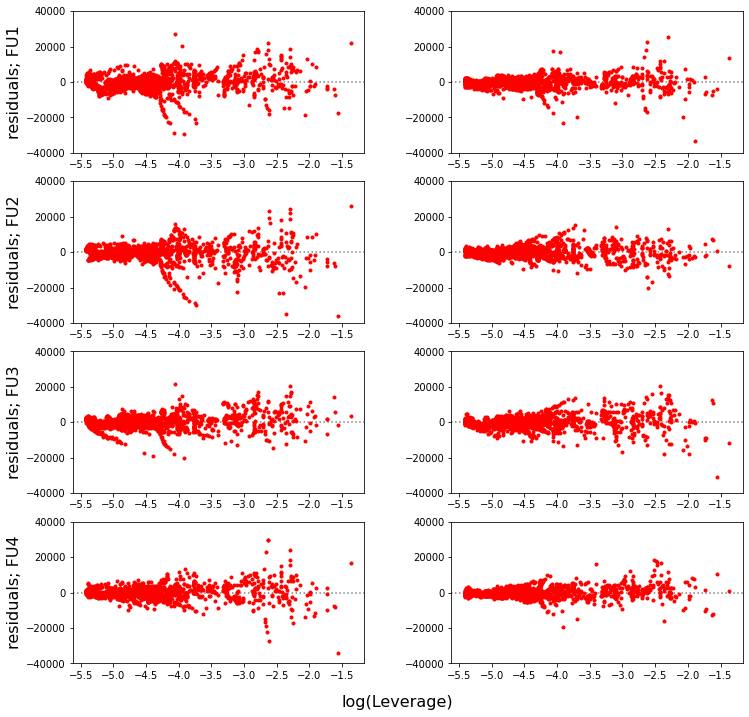

In [96]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
fig.subplots_adjust(wspace=0.3)

for i,ax in enumerate(axs.flatten()):
    ax.plot(np.log(lev), t_train.iloc[:, i] - y_train[:, i], '.r', zorder=1)
    
    if i%2 == 0:
        ax.set_ylabel('residuals; FU{}'.format(int(i/2.)+1), fontsize=16)
    
    ax.axhline(0, color='0.5', ls=':', zorder=0)
    ax.set_ylim(-4e4, 4e4)
    
fig.text(0.5, 0.08, 'log(Leverage)', va='center', ha='center', fontsize=16)